# Learning goals
After today's lesson you should be able to:
- Cluster points in space using K-means and DBSCAN

This week's lesson is a simplied version of:  
- [Chapter 8 in the Geographic Data Science textbook](https://geographicdata.science/book/notebooks/08_point_pattern_analysis.html)
- [Chapter 10 in Geographic Data Science textbook](https://geographicdata.science/book/notebooks/10_clustering_and_regionalization.html)

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import pysal

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context(context='paper')

from pysal.explore import esda
from pysal.lib import weights
from numpy.random import seed

from esda.moran import Moran
from libpysal.weights import Queen, KNN


from sklearn.cluster import DBSCAN


import warnings

warnings.filterwarnings("ignore")

c:\Users\desai\miniforge3\envs\crp4680\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\desai\miniforge3\envs\crp4680\lib\site-packages\numba\core\decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
c:\Users\desai\miniforge3\envs\crp4680\lib\site-packages\quantecon\lss.py:20: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/depr

# K-Means: San Diego Geodemographic clustering

We return to the San Diego tracts dataset we have used earlier in the book. In this case, we will not only rely on its polygon geometries, but also on its attribute information. The data comes from the American Community Survey
(ACS) from 2017. Let us begin by reading in the data.

In [36]:
# Read file
db = gpd.read_file("https://www.dropbox.com/s/g8ete3zligcozzq/sandiego_tracts.gpkg?dl=1")

To make things easier later on, let us collect the variables we will use to
characterize Census tracts. These variables capture different aspects of the 
socioeconomic reality of each area and, taken together, provide a comprehensive
characterization of San Diego as a whole. We thus create a list with the names of the columns we will use later on:

In [3]:
cluster_variables = [
    "median_house_value",  # Median house value
    "pct_white",  # % tract population that is white
    "pct_rented",  # % households that are rented
    "pct_hh_female",  # % female-led households
    "pct_bachelor",  # % tract population with a Bachelors degree
    "median_no_rooms",  # Median n. of rooms in the tract's households
    "income_gini",  # Gini index measuring tract wealth inequality
    "median_age",  # Median age of tract population
    "tt_work",  # Travel time to work
]

Let's start building up our understanding of this
dataset through both visual and statistical summaries.
The first stop is considering the spatial distribution of each variable alone.
This will help us draw a picture of the multi-faceted view of the tracts we
want to capture with our clustering. Let's use (quantile) choropleth maps for
each attribute and compare them side-by-side:

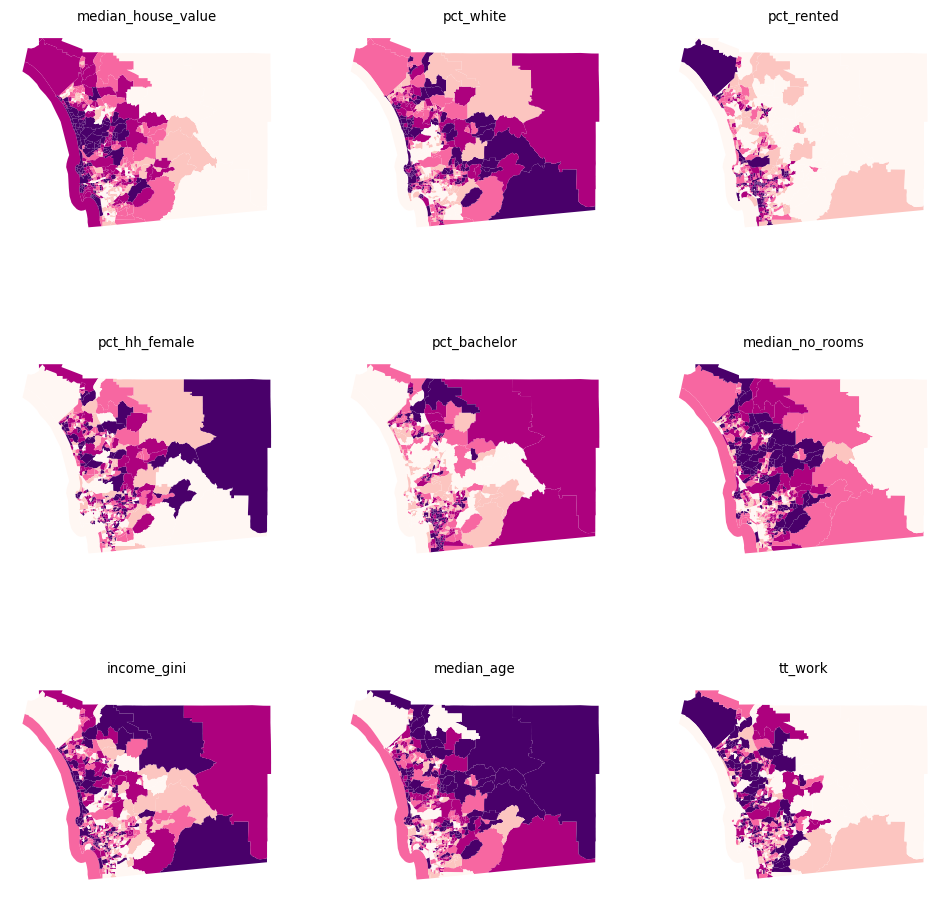

In [5]:
f, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start a loop over all the variables of interest
for i, col in enumerate(cluster_variables):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    db.plot(
        column=col,
        ax=ax,
        scheme="Quantiles",
        linewidth=0,
        cmap="RdPu",
    )
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)
# Display the figure
plt.show()

Several visual patterns jump out from the maps, revealing both commonalities as
well as differences across the spatial distributions of the individual variables.
Several variables tend to increase in value from the east to the west
(`pct_rented`, `median_house_value`, `median_no_rooms`, and `tt_work`) while others
have a spatial trend in the opposite direction (`pct_white`, `pct_hh_female`,
`pct_bachelor`, `median_age`). This will help show the strengths of clustering;
when variables have
different spatial distributions, each variable contributes distinct 
information to the profiles of each cluster. However, if all variables display very similar 
spatial patterns, the amount of useful information across the maps is 
actually smaller than it appears, so cluster profiles may be much less useful as well.
It is also important to consider whether the variables display any
spatial autocorrelation, as this will affect the spatial structure of the
resulting clusters. 

Recall from [Chapter 6](06_spatial_autocorrelation) that Moran's I is a commonly used
measure for global spatial autocorrelation. We can use it to formalise some of the
intuitions built from the maps. Recall from earlier in the book that we will need
to represent the spatial configuration of the data points through a spatial weights
matrix. We will start with queen contiguity:

In [6]:
w = Queen.from_dataframe(db)

Now let's calculate Moran's I for the variables being used. This will measure
the extent to which each variable contains spatial structure:

In [7]:
# Set seed for reproducibility
np.random.seed(123456)
# Calculate Moran's I for each variable
mi_results = [
    Moran(db[variable], w) for variable in cluster_variables
]
# Structure results as a list of tuples
mi_results = [
    (variable, res.I, res.p_sim)
    for variable, res in zip(cluster_variables, mi_results)
]
# Display on table
table = pd.DataFrame(
    mi_results, columns=["Variable", "Moran's I", "P-value"]
).set_index("Variable")
table

,Moran's I,P-value
Variable,,
median_house_value,0.646618,0.001
pct_white,0.602079,0.001
pct_rented,0.451372,0.001
pct_hh_female,0.282239,0.001
pct_bachelor,0.433082,0.001
median_no_rooms,0.538996,0.001
income_gini,0.295064,0.001
median_age,0.381440,0.001
tt_work,0.102748,0.001


Each of the variables displays significant positive spatial autocorrelation,
suggesting clear spatial structure in the socioeconomic geography of San
Diego. This means it is likely the clusters we find will have
a non random spatial distribution.

Spatial autocorrelation only describes relationships between observations for a
single attribute at a time.
So, the fact that all of the clustering variables are positively autocorrelated does not
say much about how attributes co-vary over space. To explore cross-attribute relationships,
we need to consider the spatial correlation between variables. We will take our first dip
in this direction exploring the bivariate correlation in the maps of covariates themselves.
This would mean that we would be comparing each pair of choropleths to look for associations
and differences. Given there are nine attributes, there are 36 pairs of maps that must be
compared. 

This would be too many maps to process visually. Instead, we focus directly
on the bivariate relationships between each pair of attributes, devoid for now of geography, and use a scatterplot matrix.

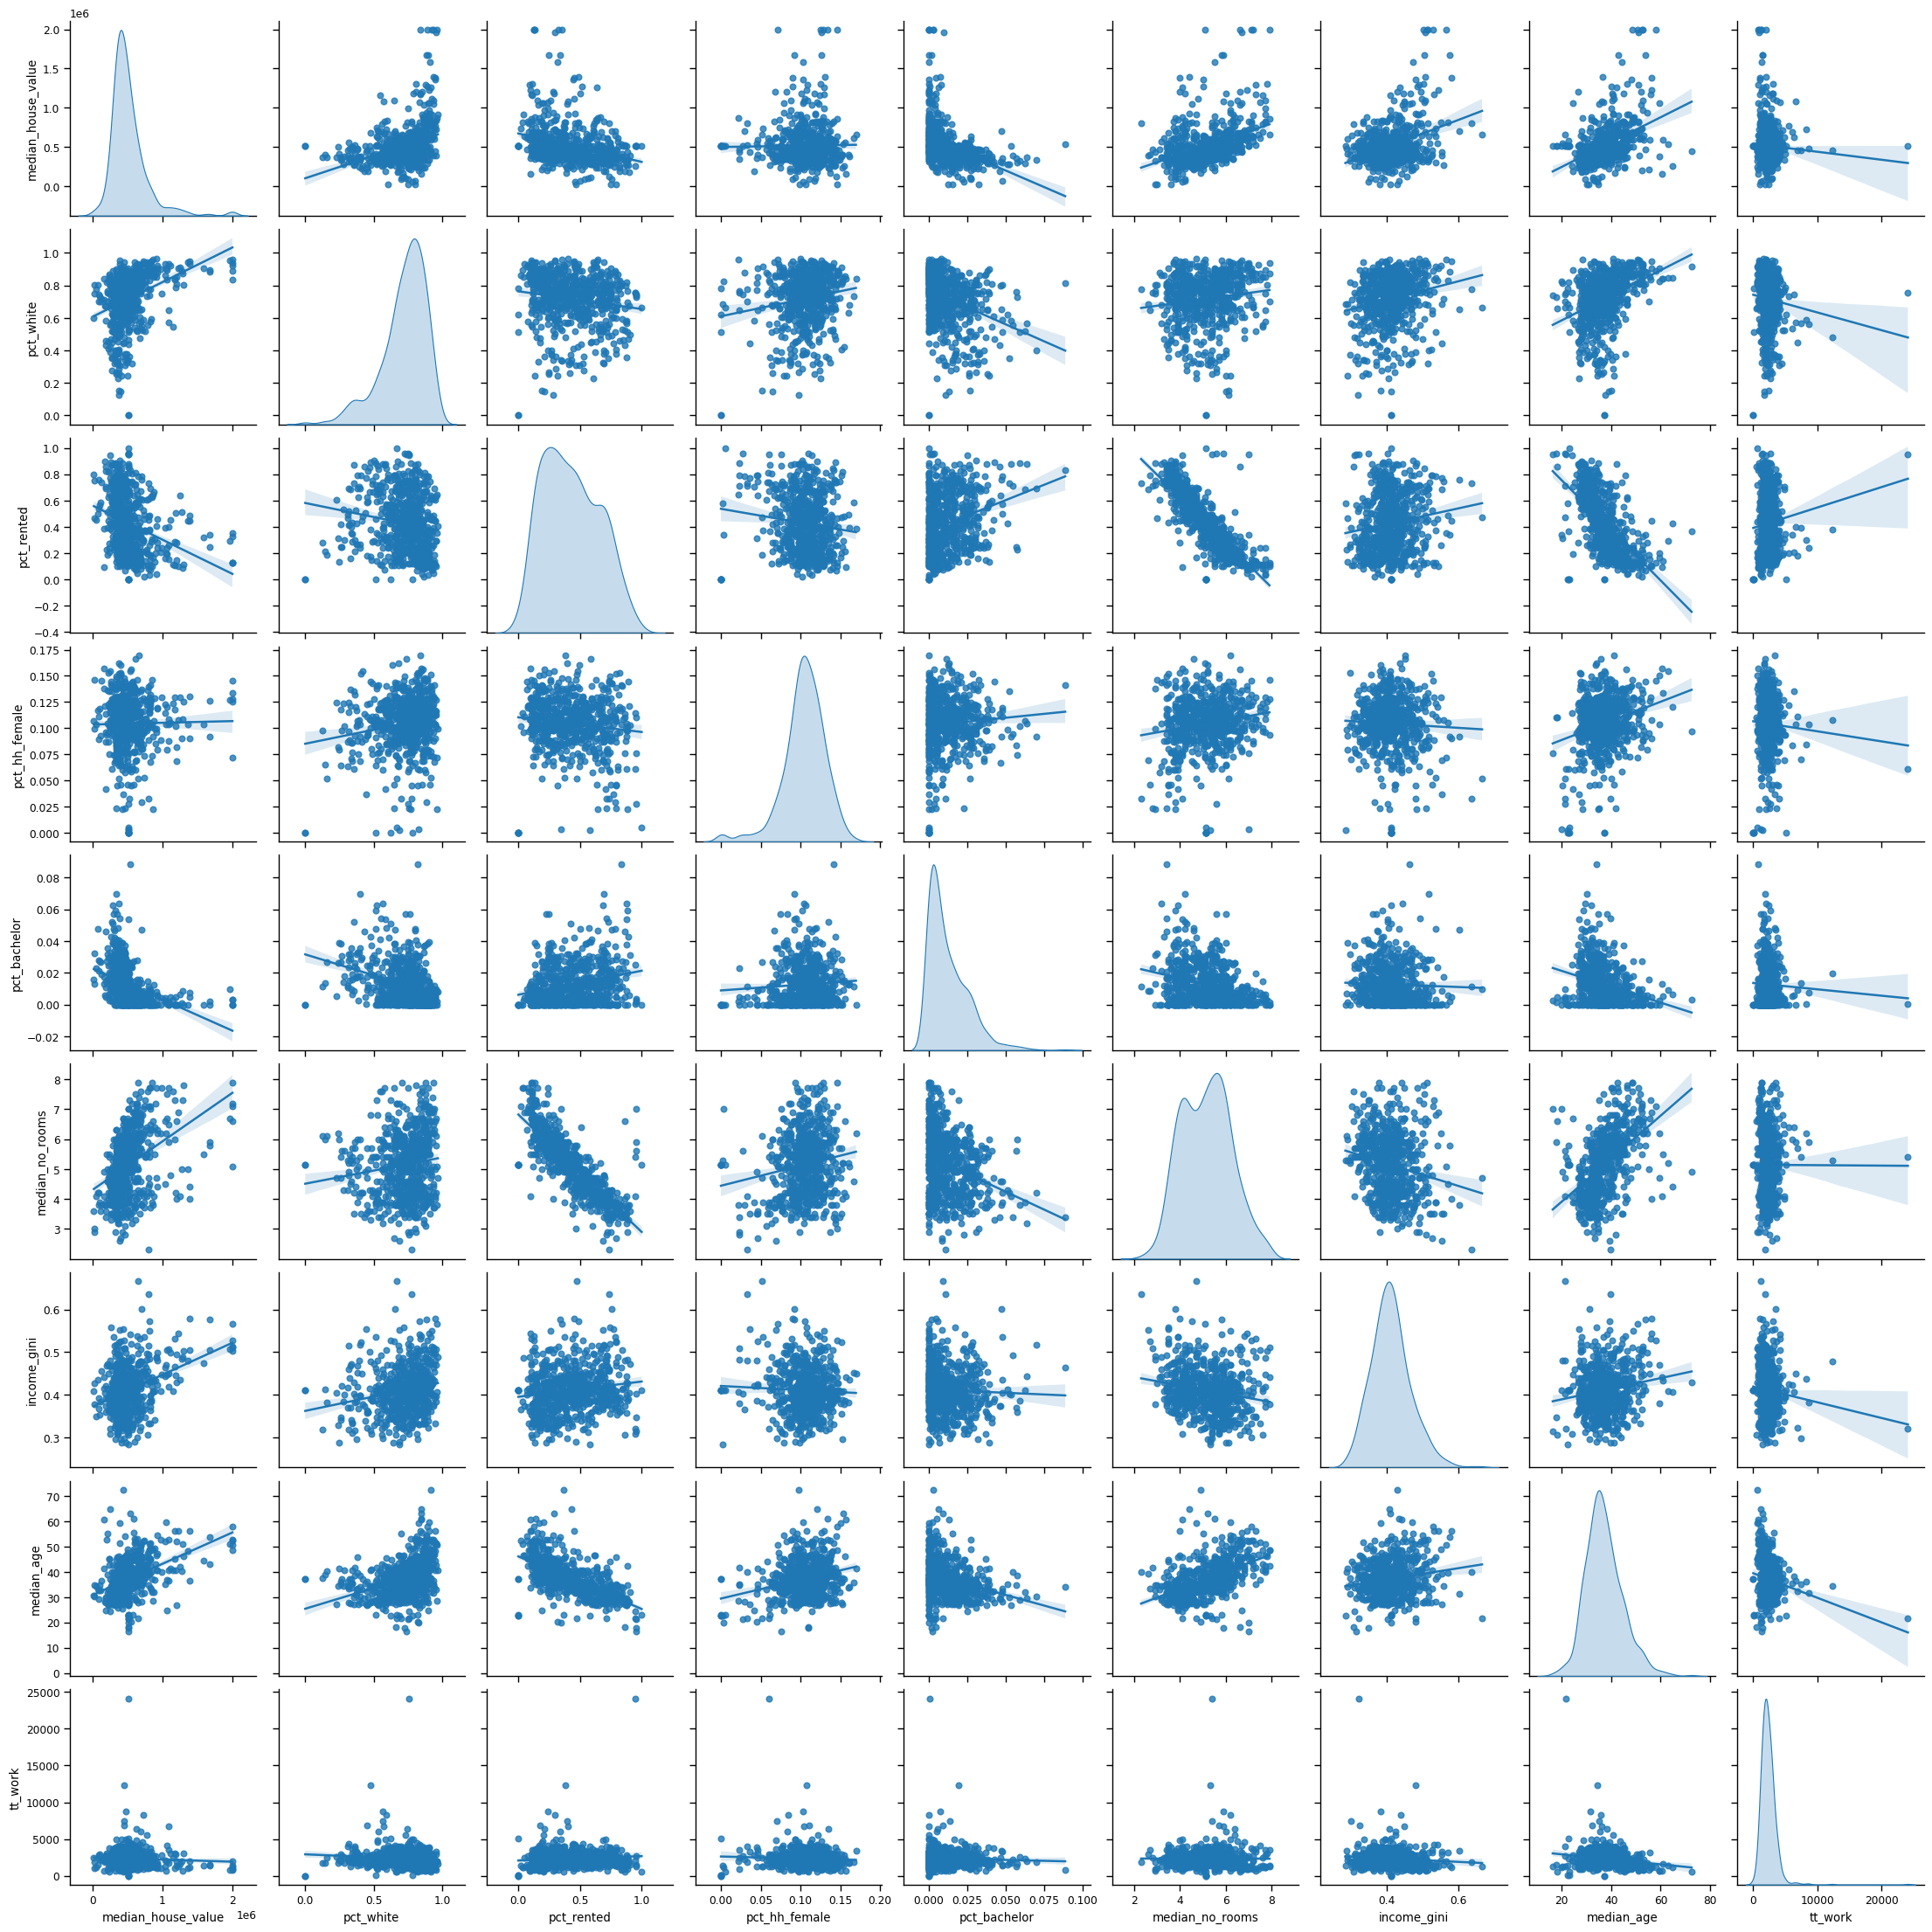

In [8]:
_ = sns.pairplot(
    db[cluster_variables], kind="reg", diag_kind="kde"
)

Two different types of plots are contained in the scatterplot matrix. On the
diagonal are the density functions for the nine attributes. These allow for an
inspection of the univariate distribution of the values for each attribute.
Examining these we see that our selection of variables includes some that are
negatively skewed (`pct_white` and `pct_hh_female`) as well as positively skewed
(`median_house_value`, `pct_bachelor`, and `tt_work`).

The second type of visualization lies in the off-diagonal cells of the matrix; 
these are bi-variate scatterplots. Each cell shows the association between one
pair of variables. **Several of these cells indicate positive linear
associations (`median_age` Vs. `median_house_value`, `median_house_value` Vs. `median_no_rooms`)
while other cells display negative correlation (`median_house_value` Vs. `pct_rented`,
`median_no_rooms` Vs. `pct_rented`, and `median_age` Vs. `pct_rented`)**. The one variable
that tends to have consistently weak association with the other variables is
`tt_work`, and in part this appears to reflect its rather concentrated 
distribution as seen on the lower right diagonal corner cell.

Indeed, this kind of concentration in values is something you need to be very aware of in clustering contexts. *Distances between datapoints* are of paramount importance in clustering applications. In fact, (dis)similarity between observations is calculated as the statistical distance between themselves. **Because distances are sensitive to the units of measurement, cluster solutions can change when you re-scale your data.**

For example, say we locate an observation based on only two variables: house price and gini coefficient. In this case:

In [9]:
db[["income_gini", "median_house_value"]].head()

,income_gini,median_house_value
0,0.5355,732900.000000
1,0.4265,473800.000000
2,0.4985,930600.000000
3,0.4003,478500.000000
4,0.3196,515570.896382


The distance between observations in terms of these variates can be computed easily using `scikit-learn`:

In [10]:
from sklearn import metrics

In [11]:
metrics.pairwise_distances(
    db[["income_gini", "median_house_value"]].head()
).round(4)

array([[     0.    , 259100.    , 197700.    , 254400.    , 217329.1036],
       [259100.    ,      0.    , 456800.    ,   4700.    ,  41770.8964],
       [197700.    , 456800.    ,      0.    , 452100.    , 415029.1036],
       [254400.    ,   4700.    , 452100.    ,      0.    ,  37070.8964],
       [217329.1036,  41770.8964, 415029.1036,  37070.8964,      0.    ]])

In this case, we know that the housing values are in the hundreds of thousands, but the Gini coefficient (which we discussed in the previous chapter) is constrained to fall between zero and one. So, for example, the distance between the first two observations is nearly totally driven by the difference in median house value (which is 259100 dollars) and ignores the difference in the Gini coefficient (which is about .11). Indeed, a change of a single dollar in median house value will correspond to *the maximum possible* difference in Gini coefficients. So, a clustering algorithm that uses this distance to determine classifications will pay a lot of attention to median house value, but very little to the Gini coefficient! 

Therefore, *as a rule*, we standardize our data when clustering. There are many different methods of standardization offered in the `sklearn.preprocessing` module, and these map onto the main methods common in applied work. We review a small subset of them here. The `scale()` method subtracts the mean and divides by the standard deviation:

$$ z = \frac{x_i - \bar{x}}{\sigma_x}$$

This "normalizes" the variate, ensuring the re-scaled variable has a mean of zero and a variance of one. However, the variable can still be quite skewed, bimodal, etc, and insofar as the mean and vairance may be affected by outliers in a given variate, the scaling can be too dramatic. One alternative intended to handle outliers better is `robust_scale()`, which uses the median and the interquartile range in the same fashion:

$$ z = \frac{x_i - \tilde{x}}{\lceil x \rceil_{75} - \lceil x \rceil_{25}}$$

where $\lceil x \rceil_p$ represents the value of the $p$th percentile of $x$. Alternatively, sometimes it is useful to ensure that the maximum of a variate is $1$ and the minimum is zero. In this instance, the `minmax_scale()` is appropriate: 

$$ z = \frac{x - min(x)}{max(x-min(x))} $$

In most clustering problems, the `robust_scale()` or `scale()` methods are useful. Further, transformations of the variate (such as log-transforming or Box-Cox transforms) can be used to nonlinearly rescale the variates, but these generally should be done before the above kinds of scaling. Here, we will analyze robust-scaled variables. To detach the scaling from the analysis, we will perform the former now, creating a scaled view of our data which we can use later for clustering. For this, we import the scaling method:

In [12]:
from sklearn.preprocessing import robust_scale

## robust_scale is a function that scales the data to have a median of 0 and a
## standard deviation of 1. This is useful for clustering algorithms that are
## sensitive to the scale of the data.

And create the `db_scaled` object which contains only the variables we are interested in, scaled:

In [13]:
db[cluster_variables]

,median_house_value,pct_white,pct_rented,pct_hh_female,pct_bachelor,median_no_rooms,income_gini,median_age,tt_work
0,732900.000000,0.916988,0.373913,0.052896,0.000000,3.9,0.5355,37.1,1299.0
1,473800.000000,0.790558,0.205144,0.109190,0.004663,6.5,0.4265,41.2,1970.0
2,930600.000000,0.880250,0.279029,0.078999,0.006077,6.2,0.4985,54.4,1702.0
3,478500.000000,0.800598,0.196512,0.090806,0.006547,6.6,0.4003,42.3,3390.0
4,515570.896382,0.753799,0.949887,0.060789,0.000569,5.4,0.3196,21.8,24143.0
...,...,...,...,...,...,...,...,...,...
623,507000.000000,0.717762,0.127660,0.102956,0.011213,6.1,0.3628,41.6,3512.0
624,427300.000000,0.761313,0.341730,0.108168,0.000000,5.2,0.3498,36.2,1681.0
625,448300.000000,0.946018,0.111605,0.117278,0.004942,6.6,0.3336,44.5,2101.0
626,504400.000000,0.857423,0.098882,0.098858,0.004894,5.9,0.4050,46.0,1373.0


In [14]:
db_scaled = robust_scale(db[cluster_variables])

In [15]:
db_scaled[0]

array([ 1.16897565,  0.88747229, -0.07925532, -1.85025225, -0.50838531,
       -0.7310384 ,  1.93719258,  0.1011236 , -0.6982584 ])



In conclusion, exploring the univariate and bivariate relationships is a good first step into building
a fully multivariate understanding of a dataset. To take it to the next level, we would
want to know to what extent these pair-wise relationships hold across different attributes,
and whether there are patterns in the "location" of observations within the scatter plots.
For example, do nearby dots in each scatterplot of the matrix represent the _same_ observations?
This type of questions are exactly what clustering helps us explore.

## Geodemographic Clusters in San Diego Census Tracts

Geodemographic analysis is a form of multivariate
clustering where the observations represent geographical areas {cite}`webber2018predictive`. The output
of these clusterings is nearly always mapped. Altogether, these methods use
multivariate clustering algorithms to construct a known number of
clusters ($k$), where the number of clusters is typically much smaller than the 
number of observations to be clustered. Each cluster is given a unique label,
and these labels are mapped. Using the clusters' profile and label, the map of 
labels can be interpreted to get a sense of the spatial distribution of 
socio-demographic traits. The power of (geodemographic) clustering comes
from taking statistical variation across several dimensions and compressing it
into a single categorical one that we can visualize through a map. To
demonstrate the variety of approaches in clustering, we will show two
distinct but very popular clustering algorithms: k-means and Ward's hierarchical method.

### K-means

K-means is probably the most widely used approach to
cluster a dataset. The algorithm groups observations into a
pre-specified number of clusters so that that each observation is
closer to the mean of its own cluster than it is to the mean of any other cluster.
The k-means problem is solved by iterating between an assignment step and an update step. 
First, all observations are randomly assigned one of the $k$ labels. Next, the 
multivariate mean over all covariates is calculated for each of the clusters.
Then, each observation is reassigned to the cluster with the closest mean. 
If the observation is already assigned to the cluster whose mean it is closest to,
the observation remains in that cluster. This assignment-update process continues
until no further reassignments are necessary.

The nature of this algorithm requires us to select the number of clusters we 
want to create. The right number of clusters is unknown in practice. For
illustration, we will use $k=5$ in the `KMeans` implementation from
`scikit-learn`. 

In [16]:
# Initialise KMeans instance
from sklearn.cluster import KMeans

This illustration will also be useful as virtually every algorithm in `scikit-learn`,
the (Python) standard library for machine learning, can be run in a similar fashion.
To proceed, we first create a `KMeans` clusterer object that contains the description of
all the parameters the algorithm needs (in this case, only the number of clusters):

In [17]:
# Initialise KMeans instance
kmeans = KMeans(n_clusters=5)

Next, we set the seed for reproducibility and call the `fit` method to compute the algorithm specified in `kmeans` to our scaled data:

In [18]:
# Set the seed for reproducibility
np.random.seed(1234)
# Run K-Means algorithm
k5cls = kmeans.fit(db_scaled)

Now that the clusters have been assigned, we can examine the label vector, which 
records the cluster to which each observation is assigned:

In [19]:
# Print first five labels
k5cls.labels_[:5]

array([2, 1, 3, 1, 4])

In this case, the first observation is assigned to cluster 2, the second and fourth ones are assigned to cluster 1, the third to number 3 and the fifth receives the label 4. It is important
to note that the integer labels should be viewed as denoting membership only &mdash;
the numerical differences between the values for the labels are meaningless.
The profiles of the various clusters must be further explored by looking
at the values of each dimension. But, before we do that, let's make a map.

### Spatial Distribution of Clusters

Having obtained the cluster labels, we can display the spatial
distribution of the clusters by using the labels as the categories in a
choropleth map. This allows us to quickly grasp any sort of spatial pattern the 
clusters might have. Since clusters represent areas with similar
characteristics, mapping their labels allows to see to what extent similar areas tend
to have similar locations.
Thus, this gives us one map that incorporates the information from all nine covariates.

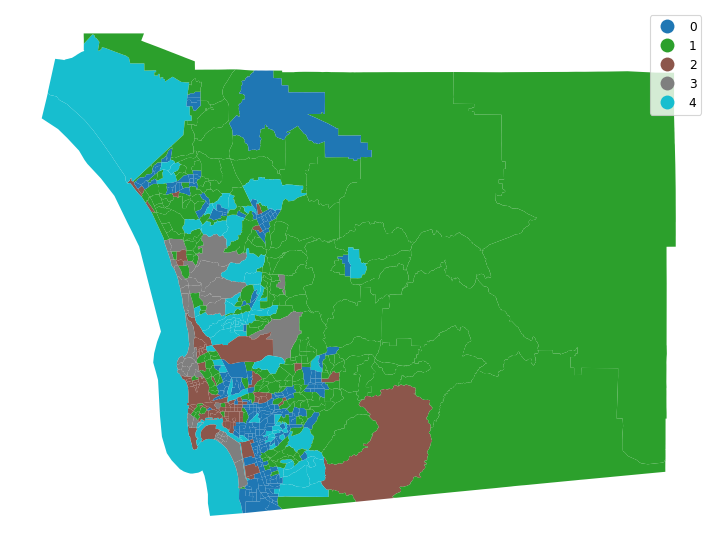

In [20]:
# Assign labels into a column
db["k5cls"] = k5cls.labels_
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including
# a legend and with no boundary lines
db.plot(
    column="k5cls", categorical=True, legend=True, linewidth=0, ax=ax
)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()

# DBSCAN: The Tokyo photographs dataset

The rise of new forms of data such as geo-tagged photos uploaded to online services is creating new ways for researchers to study and understand cities. Where do people take pictures? When are those pictures taken? Why do certain places attract many more photographers than others? All these questions and more become more than just rhetorical ones when we consider, for example,  online photo hosting services as volunteered geographic information (VGI, {cite}`Goodchild2007citizens`). In this chapter we will explore metadata from a sample of geo-referenced images uploaded to [Flickr](https://www.flickr.com/) and extracted thanks to the [100m Flickr dataset](https://webscope.sandbox.yahoo.com/catalog.php?datatype=i&did=67). In doing so, we will introduce a few approaches that help us better understand the distribution and characteristics of a point pattern. 

To get started, let's load the packages we will need in this example. 

Then, let us load some data about picture locations from Flickr:


In [21]:
db = pd.read_csv("https://www.dropbox.com/s/jeiw3921imfto9q/tokyo_clean.csv?dl=1")

The table contains the following information about the sample of 10,000 photographs: the ID of the user who took the photo; the location expressed as latitude and longitude columns; a transformed version of those coordinates expressed in Pseudo Mercator; the timestamp when the photo was taken; and the URL where the picture they refer to is stored online:

In [22]:
db.head()

,user_id,longitude,latitude,date_taken,photo/video_page_url,x,y
0,10727420@N00,139.700499,35.674000,2010-04-09 17:26:25.0,http://www.flickr.com/photos/10727420@N00/4545...,1.555139e+07,4.255856e+06
1,8819274@N04,139.766521,35.709095,2007-02-10 16:08:40.0,http://www.flickr.com/photos/8819274@N04/26503...,1.555874e+07,4.260667e+06
2,62068690@N00,139.765632,35.694482,2008-12-21 15:45:31.0,http://www.flickr.com/photos/62068690@N00/3125...,1.555864e+07,4.258664e+06
3,49503094041@N01,139.784391,35.548589,2011-11-11 05:48:54.0,http://www.flickr.com/photos/49503094041@N01/6...,1.556073e+07,4.238684e+06
4,40443199@N00,139.768753,35.671521,2006-04-06 16:42:49.0,http://www.flickr.com/photos/40443199@N00/2482...,1.555899e+07,4.255517e+06


## Visualizing Point Patterns

There are many ways to visualize geographic point patterns, and the choice of method depends on the intended message. 

### Showing Patterns as Dots on a Map

The first step to get a sense of what the spatial dimension of this dataset looks like is to plot it. At its most basic level, we can generate a scatter plot with `sns`:


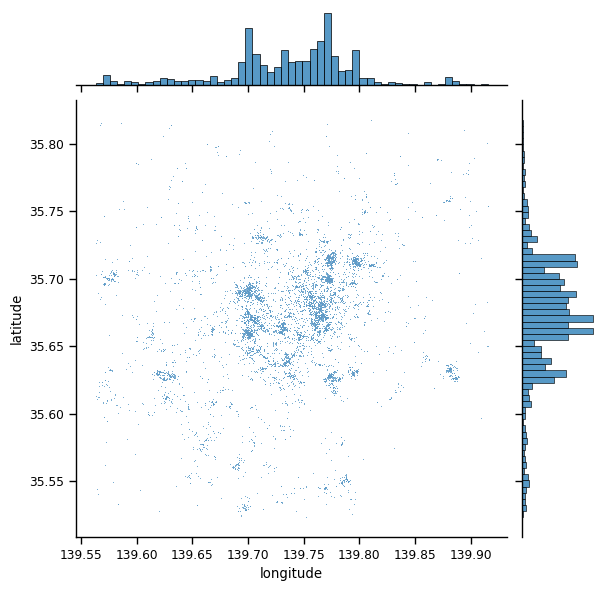

In [23]:
# Generate scatter plot
sns.jointplot(x="longitude", y="latitude", data=db, s=0.5)

### Showing Density with Hex-binning

Consider our second problem: cluttering. When too many photos are concentrated in some areas of, plotting opaque dots on top of one another can make it hard to discern any pattern and explore its nature. For example, in the middle of the map, towards the right, there appears to be the highest concentration of pictures taken; the sheer amount of dots on the maps in some parts obscures whether all of that area receives as many pics or whether, within there, some places receive a particularly high degree of attention.

One solution to get around cluttering relates to what we referred to earlier as moving from {ref}`"tables to surfaces" <ch03-surfaces_as_tables>`. We can now recast this approach as a *spatial* or *2-dimensional histogram*. Here, we generate a regular grid (either squared or hexagonal), count how many dots fall within each grid cell, and present it as we would any other choropleth. This is attractive because it is simple, intuitive and, if fine enough, the regular grid removes some of the area distortions choropleth maps may induce. For this illustration, let us use use hexagonal binning (sometimes called hexbin) because it has slightly nicer properties than squared grids, such as less shape distortion and more regular connectivity between cells. Creating a hexbin 2-d histogram is straightforward in Python using the `hexbin` function:


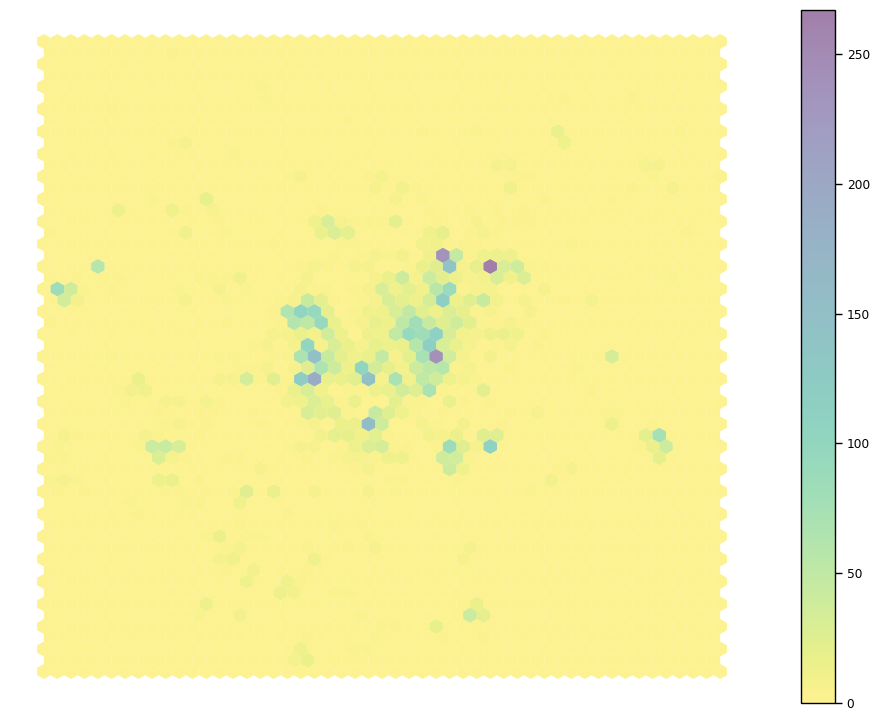

In [24]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(12, 9))
# Generate and add hexbin with 50 hexagons in each
# dimension, no borderlines, half transparency,
# and the reverse viridis colormap
hb = ax.hexbin(
    db["x"],
    db["y"],
    gridsize=50,
    linewidths=0,
    alpha=0.5,
    cmap="viridis_r",
)

# Add colorbar
plt.colorbar(hb)
# Remove axes
ax.set_axis_off()

## Identifying clusters

From the many spatial point clustering algorithms, we will cover one called DBSCAN (Density-Based Spatial Clustering of Applications, {cite}`ester1996density`. DBSCAN is a widely used algorithm that originated in the area of knowledge discovery and machine learning and that has since spread into many areas, including the analysis of spatial points. In part, its popularity resides in its intellectual simplicity and computational tractability. In some ways, we can think of DBSCAN as a point pattern counterpart of the local statistics we explored in [Chapter 7](07_local_autocorrelation). They do however differ in fundamental ways. Unlike the local statistics we have seen earlier, DBSCAN is not based on an inferential framework, but it is instead a deterministic algorithm. This implies that, unlike the measures seen before, we will not be able to estimate a measure of the degree to which the clusters found are compatible with cases of spatial randomness.  



From the point of view of **DBSCAN, a cluster is a concentration of at least `m` points, each of them within a distance of `r` of at least another point in the cluster**. Following this definition, the algorithm classifies each point in our pattern into three categories:

* *Noise*, for those points outside a cluster.
* *Cores*, for those points inside a cluster with at least `m` points in the cluster within distance `r`.
* *Borders* for points inside a cluster with less than `m` other points in the cluster within distance `r`.

Here is a cluster where `m` is 3 points for a given `r` distance.

</figure>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/af/DBSCAN-Illustration.svg/400px-DBSCAN-Illustration.svg.png" alt="drawing" width="600" style="display: block; margin: 0 auto"/>
</figure>

The flexibility (but also some of the limitations) of the algorithm resides in that both `m` and `r` need to be specified by the user before running DBSCAN. This is a critical point, as their value can influence significantly the final result. Before exploring this in greater depth, let us get a first run at computing `DBSCAN` in Python:


In [25]:
# Define DBSCAN
clusterer = DBSCAN()
# Fit to our data
clusterer.fit(db[["x", "y"]])

DBSCAN()

Following the standard interface in scikit-learn, we first define the algorithm we want to run (creating the `clusterer` object) and then we *fit* it to our data. Once fit, `clusterer` contains the required information to access all the results of the algorithm. The `core_sample_indices_` attribute contains the indices (order, starting from zero) of each point which is classified as a *core*. We can have a peek into it to see what it looks like:


In [26]:
# Print the first 5 elements of `cs`
clusterer.core_sample_indices_[:5]

array([ 1, 22, 30, 36, 42], dtype=int64)

The printout above tells us that the second (remember, Python starts counting at zero!) point in the dataset is a core, as are the 23rd, 31st, 36th, and 43rd points. This attribute has a variable length, depending on how many cores the algorithm finds.

The second attribute of interest is `labels_`:

In [27]:
clusterer.labels_[:5]

array([-1,  0, -1, -1, -1], dtype=int64)

The labels object always has the same length as the number of points used to run DBSCAN. Each value represents the index of the cluster a point belongs to. If the point is classified as *noise*, it receives a -1. Above, we can see that the second point belongs to cluster 1, while the others in the list are effectively not part of any cluster. To make thinks easier later on, let us turn the labels into a `Series` object that we can index in the same way as our collection of points:


In [28]:
lbls = pd.Series(clusterer.labels_, index=db.index)

Now we already have the clusters, we can proceed to visualize them. There are many ways in which this can be done. We will start just by coloring points in a cluster in red and noise in gray:


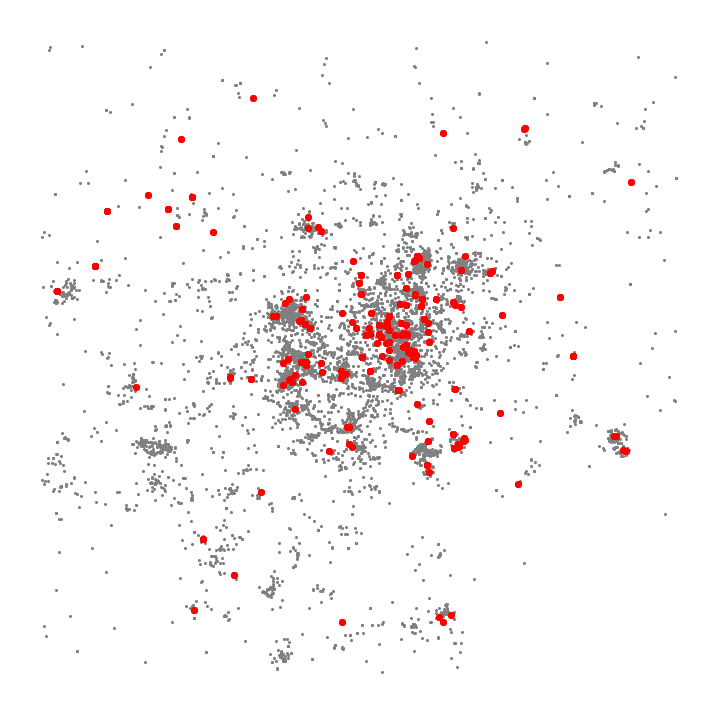

In [29]:
# Setup figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Subset points that are not part of any cluster (noise)
noise = db.loc[lbls == -1, ["x", "y"]]
# Plot noise in grey
ax.scatter(noise["x"], noise["y"], c="grey", s=5, linewidth=0)
# Plot all points that are not noise in red
# NOTE how this is done through some fancy indexing, where
#      we take the index of all points (tw) and substract from
#      it the index of those that are noise
ax.scatter(
    db.loc[db.index.difference(noise.index), "x"],
    db.loc[db.index.difference(noise.index), "y"],
    c="red",
    linewidth=0,
)

# Remove axes
ax.set_axis_off()
# Display the figure
plt.show()

Although informative, the result of this run is not particularly satisfactory. There are *way* too many points that are classified as "noise".

This is because we have run DBSCAN with the default parameters: a radius of 0.5 and a minimum of five points per cluster. Since our data is expressed in meters, a radius of half a meter will only pick up hyper local clusters. This might be of interest in some cases but, in others, it can result in odd outputs. 

If we change those parameters, can pick up more general patterns. For example, let us say a cluster needs to, at least, have roughly 1% of all the points in the dataset:


In [31]:
# Obtain the number of points 1% of the total represents
minp = np.round(db.shape[0] * 0.01)
minp

100.0

## Q.1
At the same time, let us expand the maximum radius to say, 500 meters. Then we can re-run the algorithm and plot the output, all in the same cell this time:


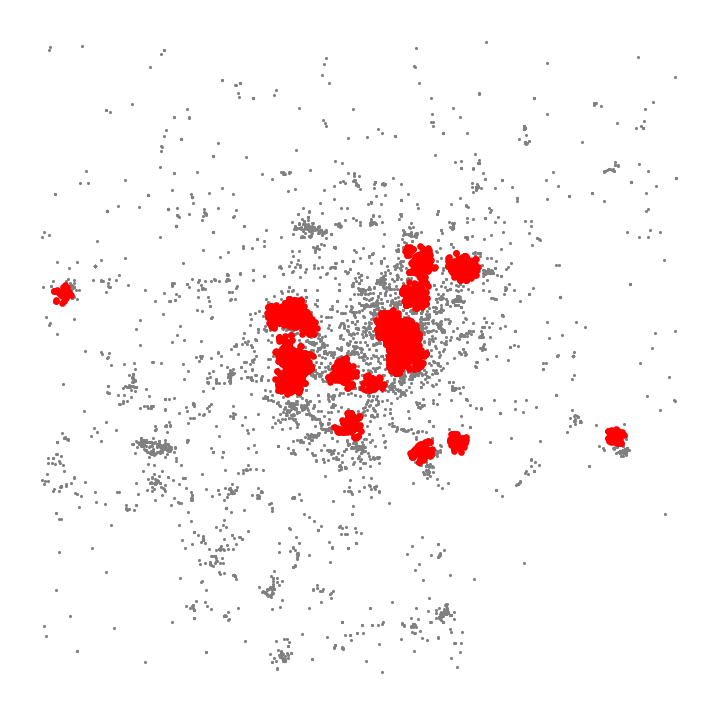

In [32]:
# INSERT YOUR CODE HERE

# Rerun DBSCAN
clusterer = DBSCAN(eps=500, min_samples=int(minp))
clusterer.fit(db[["x", "y"]])
# Turn labels into a Series
lbls = pd.Series(clusterer.labels_, index=db.index)
# Setup figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Subset points that are not part of any cluster (noise)
noise = db.loc[lbls == -1, ["x", "y"]]
# Plot noise in grey
ax.scatter(noise["x"], noise["y"], c="grey", s=5, linewidth=0)
# Plot all points that are not noise in red
# NOTE how this is done through some fancy indexing, where
#      we take the index of all points (db) and substract from
#      it the index of those that are noise
ax.scatter(
    db.loc[db.index.difference(noise.index), "x"],
    db.loc[db.index.difference(noise.index), "y"],
    c="red",
    linewidth=0,
)

# Remove axes
ax.set_axis_off()
# Display the figure
plt.show()

## Q.2
Suggest a scenario in your own work or research when you might want to use a DBSCAN algorithm with a larger `r` and and `m`. Suggest a scenario where you may want to use smaller parameters

I'm personally interested in exploring trees in urban spaces. I think DBSCAN can help me identify clusters of trees, which indicate a very green urban space. And the absence of clusters can indicate lack of vegetation at the street level.

## Q.3
In the San Diego k-means clustering example, try running the clustering with K=10, and K=20. What are the results that you get?

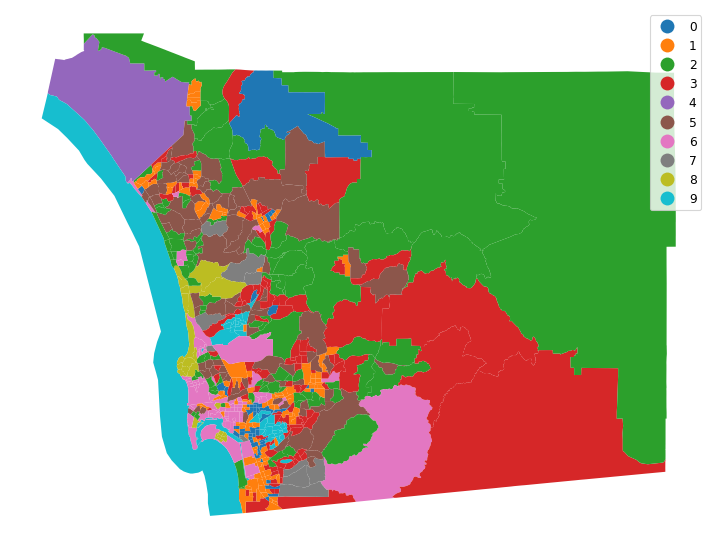

In [37]:
db = gpd.read_file("https://www.dropbox.com/s/g8ete3zligcozzq/sandiego_tracts.gpkg?dl=1")
cluster_variables = [
    "median_house_value",  # Median house value
    "pct_white",  # % tract population that is white
    "pct_rented",  # % households that are rented
    "pct_hh_female",  # % female-led households
    "pct_bachelor",  # % tract population with a Bachelors degree
    "median_no_rooms",  # Median n. of rooms in the tract's households
    "income_gini",  # Gini index measuring tract wealth inequality
    "median_age",  # Median age of tract population
    "tt_work",  # Travel time to work
]

db_scaled = robust_scale(db[cluster_variables])


# INSERT YOUR CODE HERE
kmeans10 = KMeans(n_clusters=10)
k10cls = kmeans10.fit(db_scaled)
# Assign labels into a column
db["k10cls"] = k10cls.labels_
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including
# a legend and with no boundary lines
db.plot(
    column="k10cls", categorical=True, legend=True, linewidth=0, ax=ax
)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()

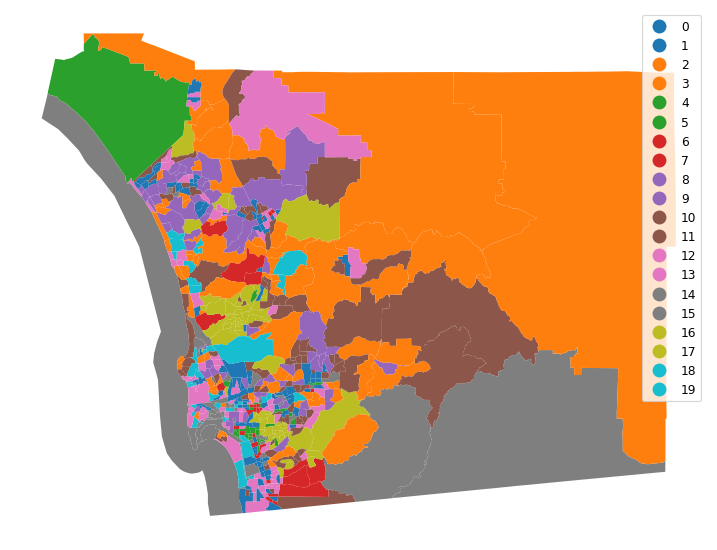

In [39]:
# INSERT YOUR CODE HERE
kmeans20 = KMeans(n_clusters=20)
k20cls = kmeans20.fit(db_scaled)
# Assign labels into a column
db["k20cls"] = k20cls.labels_
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including
# a legend and with no boundary lines
db.plot(
    column="k20cls", categorical=True, legend=True, linewidth=0, ax=ax
)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()

The difference is that there are more groups, and thus more granularity in groupings.